In [ ]:
## Image classification using convolutional neural network in pytorch

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('12QzmEk9J1PnqpqC1n38cKpPqKNMm52yi')

In [ ]:
#jovian.commit(project = '05-cifar10-cnn')

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [270]:
project_name = 'My-cifer10-cnn-on-gpu'

In [ ]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

In [ ]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path = './data')

In [ ]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

In [ ]:
airplane_files = os.listdir(data_dir + '/train/airplane')
print('no of training example in airplane training folder', len(airplane_files))
print(airplane_files[0:5])

# We will use ImageFolder class from torchvisions to load the data in Tensors

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
train_dataset = ImageFolder(data_dir + '/train', transform = ToTensor())

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
image, label = train_dataset[0]
print(classes[label])
print(image.shape)
plt.imshow(image.permute(1,2,0))

In [ ]:
print(train_dataset.classes)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
def show_example(img,label):
  print('Label:', train_dataset.classes[label], '('+str(label)+')')
  plt.imshow(img.permute(1,2,0))

In [ ]:
show_example(*train_dataset[12596])

In [ ]:
random_seed=0
torch.manual_seed(random_seed)

In [ ]:
val_size = 5000
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
print(len(train_ds),len(val_ds))

In [ ]:
jovian.log_dataset(dataset_url= dataset_url, val_size =val_size, random_seed=random_seed)

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 128

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle =True, num_workers =True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, shuffle =False, num_workers=4, pin_memory =True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images,labels in dl:
    fig,ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow = 16).permute(1,2,0))
    break

In [ ]:
show_batch(train_dl)

In [ ]:
show_batch(val_dl)

In [ ]:
show_batch(train_dl)

In [ ]:
#jovian.commit(project=project_name,environment=None)

## Convolutional Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
simple_model = nn.Sequential(nn.Conv2d(3,8,kernel_size =3, stride=1,padding =1),
                             nn.MaxPool2d(2,2))

In [ ]:
for images,labels in train_dl:
  print(images.shape)
  out = simple_model(images)
  print(out.shape)
  break

In [224]:
class ImageClassificationBase(nn.Module):
      def training_step(self,batch):
          images,labels = batch
          out = self(images)  ## properties of nn.module that it applies the forward 
    #function automatically)
          loss =F.cross_entropy(out,labels)
          return loss

      def validation_step(self,batch):
          images,labels = batch
          out = self(images)
          loss = F.cross_entropy(out,labels)
          acc = accuracy(out,labels)
          return{'val_loss': loss.detach(), 'accuracy': acc }

      def validation_epoch_end(self, outputs):
          batch_losses =[x['val_loss'] for x in outputs]
          epoch_loss =torch.stack(batch_losses).mean()
          batch_accs = [x['accuracy'] for x in outputs]
          epoch_acc = torch.stack(batch_accs).mean()
          return {'val_loss' : epoch_loss.item(), 'val_acc': epoch_acc.item()}

      def epoch_end(self,epoch, results):
          print('Epoch [{}], train_loss:{:.4f}, val_loss : {:.4f}, val_accuracy: {:.4f}'.
          format(epoch,results['train_loss'],results['val_loss'],results['val_acc']))
    
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [225]:
class Cifar10CnnModel(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3,32,kernel_size =3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size =3, stride =1, padding =1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),  ##output 64 \into 16 \into 16
    
        nn.Conv2d(64, 128, kernel_size =3, stride =1, padding =1),
        nn.ReLU(),
        nn.Conv2d(128,128, kernel_size=3, stride =1, padding =1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),  

        nn.Conv2d(128,256,kernel_size =3, stride =1, padding =1),
        nn.ReLU(),
        nn.Conv2d(256,256, kernel_size =3, stride =1, padding =1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Flatten(),   ## needs to be flatten before regression
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,10)
         )

  def forward(self,xb):
    return self.network(xb)

In [226]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [227]:
for images,labels in train_dl:
  print(images.shape)
  out = model(images)
  print(out.shape)
  print(out[0])
  break

torch.Size([128, 3, 32, 32])


RuntimeError: ignored

## Lets run this model on GPU!!

In [228]:
def get_default_device():
  #pick gpu if available else cpu
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
  #'move tensor to chosen device]'
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking =True)

class DeviceDataLoader():
  #'wrap a dataloader to move data to a device'

    def __init__(self,dl,device):
        self.dl = dl
        self.device = device 

    def __iter__(self):
     #'yield a batch of data after moving it to a device'
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
    #'number of batches'
      return len(self.dl)


In [229]:
device = get_default_device()
device

device(type='cuda')

In [230]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl , device)
to_device(model, device)

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [231]:
train_dl.device

device(type='cuda')

In [232]:
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [ ]:
#jovian.commit(project =project_name)

In [233]:
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs,lr,model,train_loader,val_loader, opt_func = torch.optim.Adam):
    history =[]
    optimizer = opt_func(model.parameters(),lr)

    for epoch in range(epochs):
    #Trainging phase
        model.train()
        train_losses =[]
        for batch in train_loader :
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
      # validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch,result)
        history.append(result)
    return history


In [234]:
model = to_device(Cifar10CnnModel(),device)  ## shifting the model to gpu

In [235]:
jovian.commit(project =project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/coolasit16/05-cifer10-cnn


'https://jovian.ai/coolasit16/05-cifer10-cnn'

In [236]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Hyperparams logged.


In [237]:
evaluate(model, val_dl)

{'val_acc': 0.0935661792755127, 'val_loss': 2.3035030364990234}

In [238]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [239]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss:1.7218, val_loss : 1.3210, val_accuracy: 0.5088
Epoch [1], train_loss:1.2021, val_loss : 1.0909, val_accuracy: 0.6128
Epoch [2], train_loss:0.9458, val_loss : 0.9231, val_accuracy: 0.6719
Epoch [3], train_loss:0.7692, val_loss : 0.7823, val_accuracy: 0.7251
Epoch [4], train_loss:0.6355, val_loss : 0.7425, val_accuracy: 0.7453
Epoch [5], train_loss:0.5091, val_loss : 0.7247, val_accuracy: 0.7544
Epoch [6], train_loss:0.4021, val_loss : 0.8153, val_accuracy: 0.7555
Epoch [7], train_loss:0.2992, val_loss : 0.8216, val_accuracy: 0.7573
Epoch [8], train_loss:0.2194, val_loss : 0.9047, val_accuracy: 0.7543
Epoch [9], train_loss:0.1753, val_loss : 1.0140, val_accuracy: 0.7605


In [240]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


In [241]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

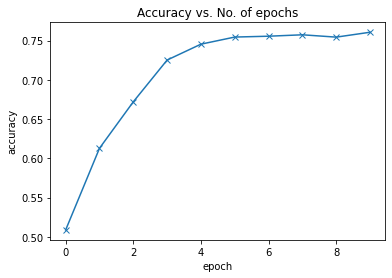

In [242]:
plot_accuracies(history)

In [243]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

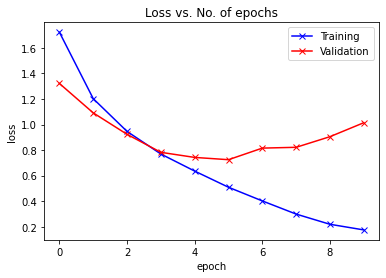

In [244]:
plot_losses(history)

In [245]:
## Testing with individual Images

In [246]:
test_dataset = ImageFolder(data_dir +'/test', transform = ToTensor())

In [252]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_dataset.classes[preds[0].item()]

Label: dog , Predicted : dog


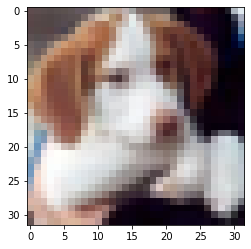

In [256]:
img,label = test_dataset[5001]
plt.imshow(img.permute(1,2,0))
print('Label:', train_dataset.classes[label], ', Predicted :' , predict_image(img,model))

Label: horse , Predicted : horse


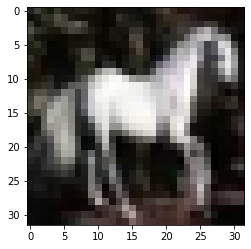

In [264]:
img,label = test_dataset[7000]
plt.imshow(img.permute(1,2,0))
print('Label:', train_dataset.classes[label], ', Predicted :' , predict_image(img,model))

In [265]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.758007824420929, 'val_loss': 1.0271157026290894}

In [266]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_acc'])

[jovian] Metrics logged.


In [267]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

In [268]:
jovian.log_metrics('cifar10-cnn.pth')

[jovian] Metrics logged.


In [271]:
jovian.commit(project =project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/coolasit16/my-cifer10-cnn-on-gpu


'https://jovian.ai/coolasit16/my-cifer10-cnn-on-gpu'